# Stochastic Gradient Descent Lab Exercises

In this laboratory session, we will investigate the various characteristics associated with Stochastic Gradient Descent, as elucidated in the instructional lectures.

Let's now turn our attention to the problem of ridge logistic regression:
$$
\min_{x \in \mathbb{R}^d} \left\{f(x) =  \frac{1}{n} \sum_{i=1}^n \log\left\{1 + \exp{\left(-b_i\langle a_i, x\rangle\right)}\right\} + \frac{\lambda}{2} \|x\|^2\right\},
$$
where $b_i \in \{-1, 1\}$ signifies the label of the $i$-th datapoint, and $a_i \in \mathbb{R}^d$ denotes the feature vector of the $i$-th datapoint.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
from functools import partial

from sklearn.datasets import make_classification

## Dataset Generation

The dataset is generated utilizing the [sklearn.datasets.make_classification](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html) function. Execute the following two cells and take note of the clear separation achieved among the data points.

In [2]:
np.random.seed(42)
n = 100
d = 5

data_matrix, labels = make_classification(n_samples = n, n_features=d, n_redundant=0, n_informative=3, class_sep = 3.0, n_clusters_per_class=1)
labels = 2*labels - 1

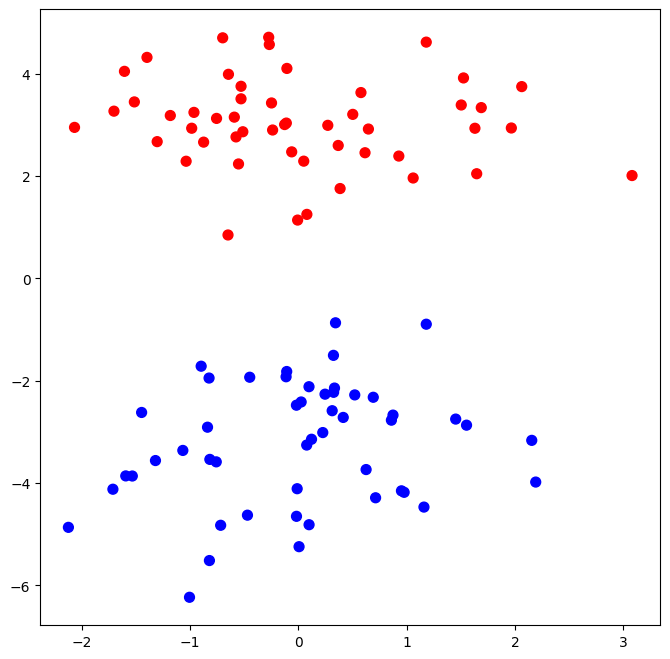

In [3]:
plt.figure(figsize=(8, 8))

plt.scatter(data_matrix[:, 1], data_matrix[:, 2], marker="o", c=labels, s=50, edgecolors="face", cmap="bwr")
plt.show()

## Implementation of the Objective Function and its Gradient

Let us revisit the objective function of this exercise:
$$
\min_{x \in \mathbb{R}^d} \left\{f(x) = \frac{1}{n}\sum_{i=1}^n f_i(x) \right\},
$$
where each individual function $f_i$ is defined as follows:
$$
f_i(x) = \log\left\{1 + \exp{\left(-b_i\langle a_i, x\rangle\right)}\right\} + \frac{\lambda}{2} \|x\|^2.
$$

Now, let us apply our knowledge of NumPy. Implement the individual function using NumPy functions.

In [4]:
def individual_log_loss(weights, features, label, regularizer):
  """ Calculate the ridge logistic loss function """
  return np.log(1 + np.exp (- label * features @ weights)) + regularizer * np.linalg.norm(weights, 2) ** 2 / 2

In [5]:
def individual_log_loss_grad(weights, features, label, regularizer):
  """ Calculate the ridge logistic loss gradient """

  scaler = - 1. / (1. + np.exp(label * features @ weights))

  return scaler * label * features + regularizer * weights

In [6]:
# def log_loss_by_ind(weights, reg, index):
#   """ Calculate the ridge logistic loss for the i-th datapoint """
#   return individual_log_loss(weights, data_matrix[i], labels[i], reg)

# def log_loss_grad_by_ind(weights, reg, index):
#   """ Calculate the ridge logistic loss gradient for the i-th datapoint  """
#   return individual_log_loss_grad(weights, data_matrix[i], labels[i], reg)

In [7]:
def log_loss(weights, data_matrix, labels, regularizer):
  """ Calculate the ridge logistic loss for all datapoints """

  log_loss_vector = np.log(1. + np.exp(- labels[:, None] * (data_matrix @ weights)))
  log_loss = log_loss_vector.mean()

  return log_loss + regularizer * np.linalg.norm(weights, 2) ** 2 / 2

In [8]:
def log_loss_grad(weights, data_matrix, labels, regularizer):
  """ Calculate the ridge logistic loss gradient """

  label_by_features = labels[:, None] * data_matrix

  scalers = - 1. / (1 + np.exp(label_by_features @ weights))

  first_part = (scalers[:, None] * label_by_features).mean(axis=0)
  second_part = regularizer * weights

  return first_part + second_part

In [9]:
x_0 = np.ones(5)
reg = 1.
log_loss_grad(x_0, data_matrix, labels, reg)

array([1.09114028, 1.07138862, 0.66019325, 0.96872002, 1.08810603])

## Obtaining a Solution using Gradient Descent

We employ a standard Gradient Descent approach to obtain the minimizer of the objective function. This solution will be essential for the purpose of performance comparison.

In [10]:
def gradient_descent(data_matrix, labels, regularizer, start_iterate, stepsize, num_iterations):
  """ Run Gradient Descent """
  x = np.copy(start_iterate)
  loss_values = [log_loss(x, data_matrix, labels, regularizer)]

  for _ in range(num_iterations):
    x -= stepsize * log_loss_grad(x, data_matrix, labels, regularizer)
    loss_values.append(log_loss(x, data_matrix, labels, regularizer))

  return x, loss_values

## Computing Important Constants

Throughout this exercise, we will need to use smoothness constant of both the main objective function $f$ and individual objective functions $f_i$. We first note that the smoothness constant of $f_i$ can be defined as follows:
$$
L_i = \frac{1}{4} \|a_i\|^2 + \lambda
$$
(Optional) Exercise 1. Prove that this constant, indeed, is a smoothness constant for $f_i$.

In the same manner, one can also show that smoothness constant for the objective function $f$ can be obtained as follows:
$$
L = \left\|\frac{1}{4n} \textbf{A}_i^\top \textbf{A}_i + \lambda \textbf{I}_d \right\|
$$,
where $\textbf{A} = \begin{bmatrix} a_1^\top \\ \dots \\ a_n^\top \end{bmatrix}$ is the feature matrix and $\textbf{I}_d$ is an identity matrix of size $d$.

(Optional) Exercise 2. Prove the formula provides a smoothness constant for $f$.

In the next cells, we compute these constants.

In [11]:
def constants(data_matrix, regularizer):
  """ Compute smoothness constants """
  individual_smoothness_constants = []
  for i in range(data_matrix.shape[0]):
    individual_smoothness_constant = 0.25 * np.linalg.norm(data_matrix[i], 2) ** 2 + regularizer
    individual_smoothness_constants.append(individual_smoothness_constant)

  n, d = data_matrix.shape
  objective_function_smoothness_constant = np.linalg.norm(data_matrix.transpose() @ data_matrix / (4 * n) + regularizer * np.eye(d))

  return np.array(individual_smoothness_constants), objective_function_smoothness_constant

In [12]:
L_is, L = constants(data_matrix, reg)

Text(0.5, 1.0, 'Distribution of constants $L_i$ across different datapoints')

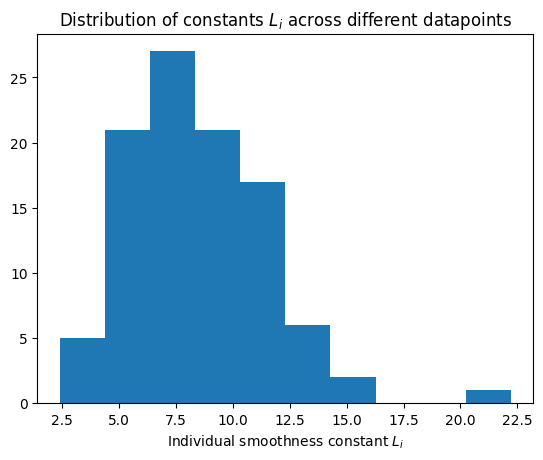

In [13]:
plt.hist(L_is)
plt.xlabel(r'Individual smoothness constant $L_i$')
plt.title(r'Distribution of constants $L_i$ across different datapoints')

In [14]:
print('Smoothness constant of the main objective equals', round(L, 1))

Smoothness constant of the main objective equals 6.7


Now we are ready to compute the minimizer of $f$ with Gradient Descent.

In [15]:
x_0 = np.ones(d)
stepsize = 1. / L
num_iterations = 100

x_solution, loss_values = gradient_descent(data_matrix, labels, reg, x_0, stepsize, num_iterations)

<ipython-input-16-05c21049166e>:6: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(bottom=0)


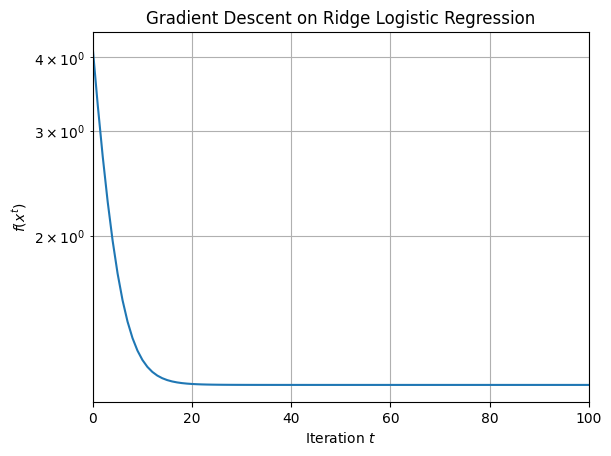

In [16]:
plt.plot(loss_values)
plt.yscale('log')
plt.xlabel(r'Iteration $t$')
plt.ylabel(r'$f(x^t)$')
plt.xlim(left=0, right=num_iterations)
plt.ylim(bottom=0)
plt.title('Gradient Descent on Ridge Logistic Regression')
plt.grid(which='both')
plt.show()

## Lab Exercise I: Stochastic Gradient Descent with Uniform Sampling launched with different stepsizes

In the first exercise, we are going to verify that the stepsize of SGD affects the size of the neigbourhood. Let us start with implementating SGD.

In [17]:
def SGD(data_matrix, labels, regularizer, x_solution, x_0, num_iterations, stepsize, p):
  """ Run Stochastic Gradient Descent for the sampling strategy 'p' """
  rng = np.random.default_rng()
  indices = rng.choice(data_matrix.shape[0], num_iterations, p=p)

  dist_values = [np.linalg.norm(x_0 - x_solution, 2) ** 2]
  x = np.copy(x_0)

  for t in range(num_iterations):
    i = indices[t]
    x -= stepsize * individual_log_loss_grad(x, data_matrix[i], labels[i], regularizer)
    dist_values.append(np.linalg.norm(x - x_solution, 2) ** 2)

  return dist_values

Stochastic Gradient Descent with Uniform Sampling can be understood as a specific scenario within the broader context of Stochastic Gradient Descent. In this scenario, each data point is sampled with an equal probability of $\frac{1}{n}$.

In [18]:
p_uniform = np.ones(n) / n
p_uniform[:5]

array([0.01, 0.01, 0.01, 0.01, 0.01])

In [19]:
SGD_US = partial(SGD, p=p_uniform)

In [20]:
print('The largest stepsize for SGD-US allowed by theory is', round(.5 / np.max(L_is), 3))

The largest stepsize for SGD-US allowed by theory is 0.023


In this experiment, we are going to run Stochastic Gradient Descent with Uniform Sampling with 3 different stepsizes: 0.0003, 0.003, 0.3. Let us revisit the main theorem of the lecture. It states that if $f$ is $\mu$-convex, and each $f_i$ is convex and $L_i$-smooth, then SGD with stepsize 0 < \gamma \leq \frac{1}{2A''}, where $A'' = max_i \frac{L_i}{n p_i}$, satisfies
$$
\mathbb{E} \|x^k - x^\ast \|^2 \leq (1 - \gamma \mu)^k\|x^0 - x^\ast\|^2 + \frac{2 \gamma \sigma_\ast^2}{\mu},
$$
where $\sigma_\ast^2 = \mathbb{E}\|g(x^\ast)\|^2 - \|\mathbb{E} g(x^\ast) \|^2$.

(Optional) Exercise 3. Verify that utilized functions in this lab exercise satisfy all the requirements of the theorem.

One notable implication of the theorem is observation that, although larger stepsize leads to faster convergence (the first element in the right-hand side converges faster to zero), it converges to the larger neigbourhood (the second element in the right-hand side grows linearly with $\gamma$). Let us verify this fact on practice.

In [21]:
x_0 = np.ones(d)
num_iterations = 30000

stepsizes = [3e-4, 3e-3, 3e-2]

distances_list = []
for stepsize in stepsizes:
  distances = SGD_US(data_matrix, labels, reg, x_solution, x_0, num_iterations, stepsize)
  distances_list.append(distances)

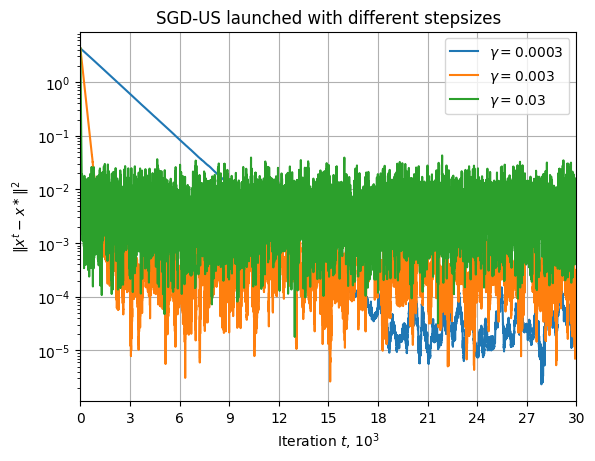

In [22]:
for ind, stepsize in enumerate(stepsizes):
  plt.plot(distances_list[ind], label=r'$\gamma=$' + str(stepsize))

# plt.plot(distances, label='small stepsize')
# plt.plot(distances_2, label='large stepsize')
plt.yscale('log')
plt.xticks(ticks=np.arange(stop=num_iterations + 1, step=num_iterations / 10), labels=np.arange(stop=num_iterations // 1000 + 1, step=num_iterations // 10000))
plt.xlabel(r'Iteration $t$, $10^3$')
plt.ylabel(r'$\|x^t - x^\ast\|^2$')
plt.xlim(left=0, right=num_iterations)
plt.grid()
plt.title('SGD-US launched with different stepsizes')
plt.legend()

As depicted in the plot, a clear correspondence can be observed: a larger step size corresponds to faster convergence but the algorithm converges to a larger neighborhood, and vice versa.

## Lab Exercise II: Uniform vs. Importance Sampling

In this exercise, we are going to explore three different sampling strategies: uniform and importance.

In [23]:
p_importance = L_is / L_is.sum()

In [24]:
def stepsize(L_is, p):
  return 0.5 * L_is.size / np.max(L_is / p)

In [25]:
stepsize_importance = stepsize(L_is, p_importance)
stepsize_importance

0.059099866350623

In [26]:
stepsize_uniform = stepsize(L_is, p_uniform)
stepsize_uniform

0.022510763564966896

In [27]:
num_iterations = 1000
x_0 = np.ones(d)

distances_uniform = SGD(data_matrix, labels, reg, x_solution, x_0, num_iterations, stepsize_uniform, p_uniform)
distances_importance = SGD(data_matrix, labels, reg, x_solution, x_0, num_iterations, stepsize_importance, p_importance)

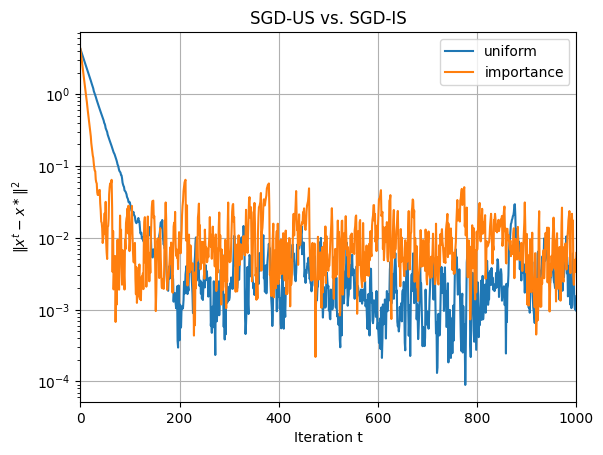

In [28]:
plt.plot(distances_uniform, label='uniform')
plt.plot(distances_importance, label='importance')
plt.legend()
plt.yscale('log')
plt.xlim(left=0, right=num_iterations)
plt.xlabel('Iteration t')
plt.ylabel(r'$\|x^t - x^\ast\|^2$')
plt.title('SGD-US vs. SGD-IS')
plt.grid()

As can be expected, SGD-IS converges faster than to the neighbourhood than SGD-US.

## (Optional) Lab Exercise III: Stochastic Gradient Descent with Minibatch Sampling

In [30]:
def SGD_minibatch(data_matrix, labels, regularizer, x_solution, batch_size, x_0, max_gradient_calls, stepsize):
  x = np.copy(x_0)
  rng = np.random.default_rng()
  number_of_gradient_calls = 0
  distances = [np.linalg.norm(x - x_solution, 2) ** 2]
  while (number_of_gradient_calls + batch_size <= max_gradient_calls):
    number_of_gradient_calls += batch_size
    indices = rng.choice(n, batch_size)

    grad_estimate = log_loss_grad(x, data_matrix[indices], labels[indices], regularizer)
    x -= stepsize * grad_estimate
    distances.append(np.linalg.norm(x - x_solution, 2) ** 2)
  return distances

In [31]:
def stepsize_minibatch(L_is, L, batch_size):
  max_L_i = np.max(L_is)
  n = L_is.size
  A = ((n - batch_size) * max_L_i + n * (batch_size - 1) * L) / (batch_size * (n - 1))
  return .5 / A

In [40]:
batch_sizes = [1, 2, 4, 5, 10, 20, 50, 100]

total_number_of_gradient_calls = 2000
x_0 = np.ones(d)
distances_list = []

for batch_size in batch_sizes:
  stepsize = stepsize_minibatch(L_is, L, batch_size)
  distances_list.append(SGD_minibatch(data_matrix, labels, reg, x_solution, batch_size, x_0, total_number_of_gradient_calls, stepsize))

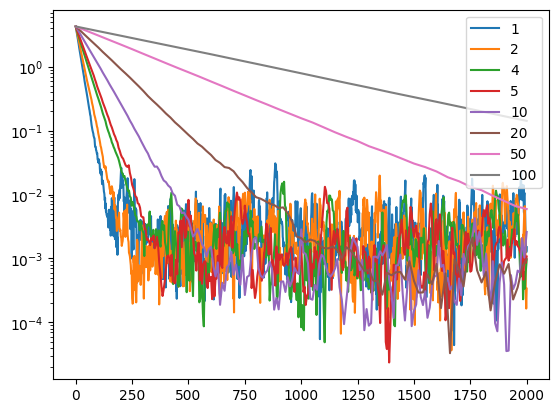

In [41]:
for ind, batch_size in enumerate(batch_sizes):
  grad_calls = np.arange(start=0, stop=total_number_of_gradient_calls + 1, step=batch_size)
  plt.plot(grad_calls, distances_list[ind], label=batch_size)

plt.legend()
plt.yscale('log')